# Baseline Model: Holt Winter Exponential Smoothing (HWES)


In this notebook, we forecast the **fastest Bitcoin transaction fee (sats/vByte)** for the next 24 hours using **Holt-Winters Exponential Smoothing (HWES)**.

---

### I. Why HWES? Additive or Multiplicative?

HWEST is a powerful method for time series forecasting that captures both **trend** and **seasonality**. It can handle both **additive** and **multiplicative** seasonality, making it flexible for different types of data. 

Recall from our EDA that Bitcoin transactions fees are proven both stationary and have a minimal fee of 1 sat/vByte, which suggests that dataset is fit for multiplicative modeling as all values are strictly positive. In addition, we analyzed the seasonality and trend of the time series using both **additive** and **multiplicative** decompositions. Here's what we found:

**✅ Additive Decomposition**

- Seasonal pattern has **constant amplitude** regardless of trend level.
- Works well when seasonality is **independent of the trend level**.
- Residuals look okay but large spikes (likely outliers) are present.

✅ **Multiplicative Decomposition**

- Seasonal component **scales with the level of the series** (i.e., as fees rise, seasonal amplitude increases).
- This fits **real-world Bitcoin fee behavior more accurately**:
    - High congestion periods (e.g., spikes in March) show **amplified seasonal patterns**.
    - Multiplicative seasonality captures this well.
- Residuals are tighter and better-behaved around 0 compared to additive, except for extreme spikes, which are expected.

⚠️ **Note:** Multiplicative models require **strictly positive values**.


### II. Modeling Process Guide

1. **Data Preparation**
   - Load and preprocess the dataset.
   - Ensure all values are strictly positive (if using multiplicative model). 
   - Train-test split the data into training and test sets.

2. **Model Selection**
    - Choose between additive or multiplicative based on decomposition analysis.
    - For this notebook, we will use **multiplicative HWES** based on reasons noted above.  

3. **Hyperparameter Tuning**
   - Set parameters like seasonal periods, trend, and seasonal components.
   - Use cross-validation to find optimal parameters. 
   - `MinMaxScaler` is used to prevent numerical instability during grid search while the shift ensures values to be strictly positive

3. **Model Fitting**
   - Fit the HWES model to the training data.
    - Use appropriate seasonal periods (i.e., daily) based on data frequency.

4. **Forecasting**
   - Generate forecasts for the next 24 hours.          

5. **Evaluation**
    - Evaluate model performance using metrics like MAE, RMSE, etc.
    - Visualize forecasts against actual values.
    - Analyze residuals to check for patterns or issues.


### III. Implementation

Implementation of model can be found in the `hwes_main.py` file under `scrpts` folder. Use the following command to run the script:

```bash
python scripts/hwes_main.py
```

Note that the script will automatically read the raw dataset, preprocess it, and generate forecasts for the next 24 hours. The results will be saved in the `results` folder. Each step is modularized for clarity and reusability. Please refer to the script and function docstrings for detailed implementation and usage instructions.

In [116]:
import os
import sys  
import pickle

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
import scipy.stats as stats
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from src.read_csv_data import read_csv_data

### IV. Analysis and Results

1. Best Hyperparameters

    The best hyperparameters for the HWES model were determined through a grid search with cross-validation. The parameters were optimized to minimize a customized evaluation metric, which is combination of MAE, standard deviation penalty, shape penalty on the validation set. For details on the evaluation metric, please refer to the `custom_loss_eval.py` script under `src` folder.

    The best hyperparameters from grid search confirmed our initial observations and hypothesis that bitcoin transaction fees are of multiplicative nature with daily seasonality. These hyperparameters were used to fit the HWES model.


    In performing cross validation, we found that the optimal parameters for the HWES model were as follows:

In [43]:
RESULTS_DIR = '../results'
hyperparam_matrix = read_csv_data(os.path.join(RESULTS_DIR, 'tables', 'hwes_cv_results.csv'))
best_trend, best_seasonal, best_damped = hyperparam_matrix.iloc[0][['trend', 'seasonal', 'damped']]
print(f"Best HWES parameters: trend={best_trend}, seasonal={best_seasonal}, damped={best_damped}")

Best HWES parameters: trend=mul, seasonal=mul, damped=True



2. Forecasting Performance

    The HWES model was able to generate forecasts for the next 24 hours. The results were saved in the `results` folder, including both the forecasted values and the evaluation metrics.

    The model's performance was evaluated using metrics such as MAE, RMSE, and MAPE, standard deviation penalty, deviation error, and total loss (MAE + std penalty + deviation error). The results showed that the HWES model performed far from ideal. We will consolidate the results with other models in a different notebook.
    
    The visualization of the forecasts against the actual values showed that the model, while capturing some of the trends and seasonality, did not perform as well as expected. The forecasts were not as accurate, especially during periods of high volatility in transaction fees.

In [54]:
eval_results = read_csv_data(os.path.join(RESULTS_DIR, 'tables', 'hwes_eval_results.csv'))
eval_results.rename(columns={'Unnamed: 0': 'metrics'}, inplace=True)
eval_results

,metrics,value
0,custom_loss,2.6085
1,std_diff,0.5155
2,dev_error,0.9369
3,mae,1.1561
4,mape,0.4737
5,rmse,1.4438


In [67]:
DATA_DIR = '../data/processed/hwes'
DAILY = 96  # 24 hours & (60 / 15 mins)

test = read_csv_data(os.path.join(DATA_DIR, 'test.csv'))
forecast = read_csv_data(os.path.join(RESULTS_DIR, 'tables', 'hwes_forecast.csv'))

test_nonspike = test[ : DAILY]
forecast_nonspike = forecast[ : DAILY]

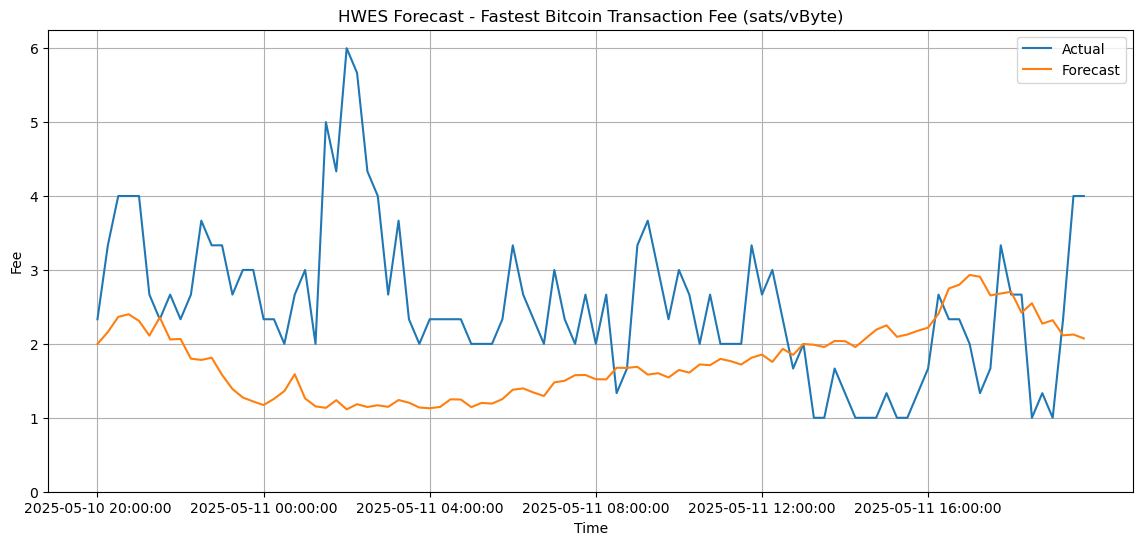

In [76]:

plt.figure(figsize=(14, 6))
plt.plot(test_nonspike["timestamp"], test_nonspike["recommended_fee_fastestFee"], label="Actual")
plt.plot(forecast_nonspike["timestamp"], forecast_nonspike["forecast"], label="Forecast")

xticks = test_nonspike["timestamp"][::16]  # Show every 16th timestamp (4 hours)
plt.xticks(xticks, rotation=0)

plt.title("HWES Forecast - Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.show()

3. Residual Analysis

    The residuals of the HWES model were analyzed to check for patterns or issues. We checked for normality and uncorrelation. This is crucial for validating the model's performance.

    We have used: 
    - Ljung-Box test to check for autocorrelation in the residuals. The results indicated that the residuals were not fully independent, suggesting that there may be some patterns or structures in the data that the model did not capture.
    - QQ plot to check for normality of the residuals. The residuals did not follow a perfect normal distribution, indicating that there may be some outliers or non-normal behavior in the data.
    - Heteroskedasticity ARCH test to check for Autoregressive Conditional Heteroskedasticity (ARCH) effects in the residuals. The results indicated that the residuals were not homoscedastic, suggesting that the variance of the residuals was not constant over time.
    
    The residuals showed some patterns, indicating that the model could not fully capture the underlying dynamics of the Bitcoin transaction fees. This suggests that while HWES is a good baseline model, it may not be sufficient for this particular time series data.

In [106]:
# read in training model (hwes_best_train model object)
MODEL_FROM = '../results/models/hwes_best_train.pkl'
with open(MODEL_FROM, 'rb') as f:
    model_fit = pickle.load(f)

train = read_csv_data(os.path.join(DATA_DIR, 'train.csv'))
train.set_index('timestamp', inplace=True)

In [113]:

train_fitted = model_fit.fittedvalues
train_residuals = train["recommended_fee_fastestFee"] - train_fitted.values


In [117]:
# Check for Autocorrelation (Ljung-Box Test)
# p-value < 0.05 indicates significant autocorrelation
lb_test = acorr_ljungbox(train_residuals.dropna(), lags=[DAILY], return_df=True)
lb_test


,lb_stat,lb_pvalue
96,381.044905,1.330475e-35


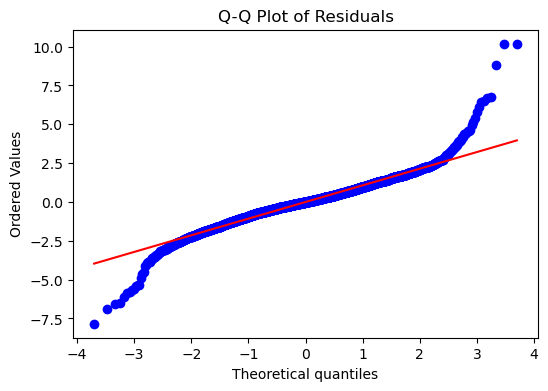

In [118]:
# Check for Normality (Q-Q Plot)
plt.figure(figsize=(6, 4))
stats.probplot(train_residuals.dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


In [120]:
# Check for Heteroskedasticity
# p-value < 0.05 indicates heteroskedasticity
arch_test = het_arch(train_residuals.dropna())
print(f"ARCH test p-value: {arch_test[1]}")

ARCH test p-value: 2.991636846964965e-211


### V. Conclusion

In this notebook, we implemented the Holt-Winters Exponential Smoothing (HWES) model to forecast Bitcoin transaction fees for the next 24 hours. The model was chosen based on the analysis of seasonality and trend in the data, and it was found to be multiplicative in nature.

However, the model's performance was not as expected, with significant errors in the forecasts. The residual analysis indicated that there were patterns and structures in the data that the model did not capture, suggesting that more advanced models may be needed for better forecasting accuracy.

We plan to explore more advanced and industry model of similar mechanisms and architectures Prophet, which is designed for forecasting time series data with strong seasonal effects and several seasons of historical data. We will also explore other models including SARIMA, and machine learning approaches like XGBoost, LSTM, and Transformers in subsequent notebooks. The goal is to improve the forecasting accuracy and better capture the dynamics of Bitcoin transaction fees.